<a href="https://colab.research.google.com/github/Abhilaksh1498/SoC-20-Chatbot/blob/master/EE338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ESPCN (Efficient Sub-Pixel CNN), is a model that reconstructs a high-resolution version of an image given a low-resolution version. 

Here, we will implement the model from the paper *Real-Time Single Image and Video Super-Resolution Using an Efficient
Sub-Pixel Convolutional Neural Network* and dataset being BSDS500.


**Link to Paper**
```
https://arxiv.org/pdf/1609.05158.pdf
```

**Datset Link**


```
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html
```





In [1]:
import tensorflow as tf

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display

In [2]:
# Downloading the dataset
# dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
# data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
# root_dir = os.path.join(data_dir, "BSDS500/data")

! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz


--2020-12-04 18:28:51--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8001::1, 2620:12a:8000::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-04 18:28:51--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2020-12-04 18:28:51--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (ww

In [ ]:
! tar zxvf BSR_bsds500.tgz 

In [15]:

crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 10


train_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode = None
)

valid_ds = image_dataset_from_directory(
    '/content/BSR/BSDS500/data',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42, label_mode = None
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [16]:
# We need to normalise pixel values in any Computer Vision task

def normalise_img(img):
    img = img / 255.0
    return img


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(normalise_img)
valid_ds = valid_ds.map(normalise_img)



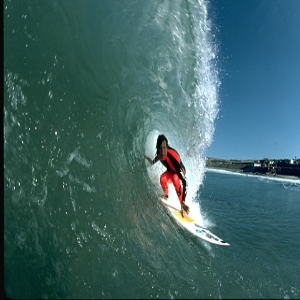

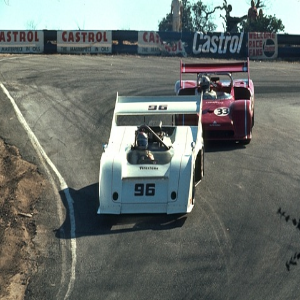

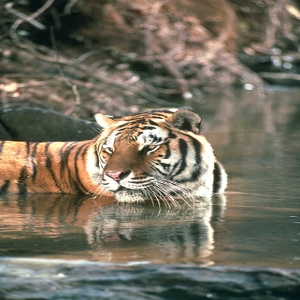

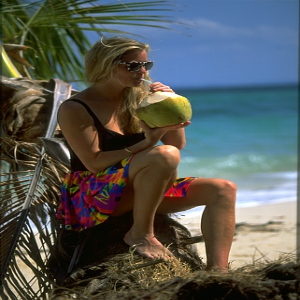

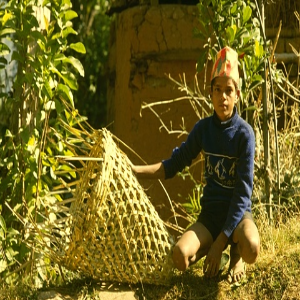

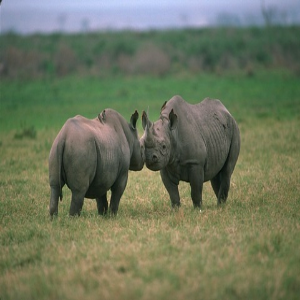

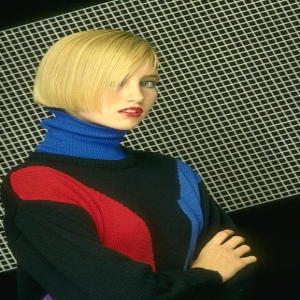

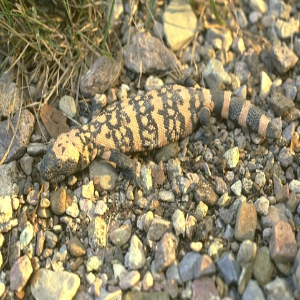

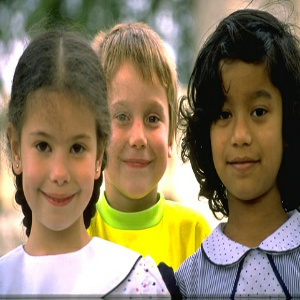

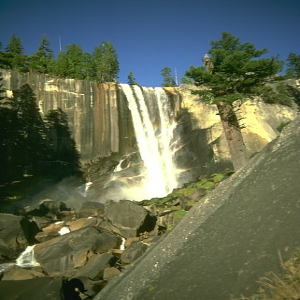

In [17]:
# This is how input images to the model looks
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))  # array_to_img function displays numpy array as image
    # this will display 10 imgs as batch_size was set to 10 previously

# Image preprocessing
We need some cropping and resizing of input and output images to be fed to model before during training.

Here we convert RGB img to YUV space and retain only Y component followed by resizing image

In [18]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)


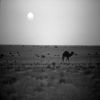

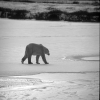

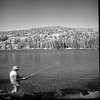

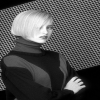

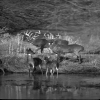

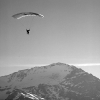

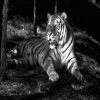

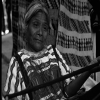

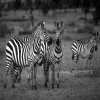

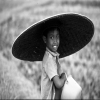

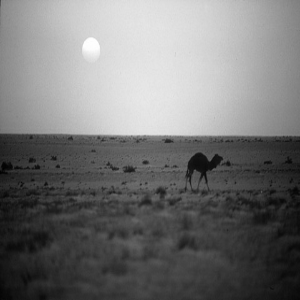

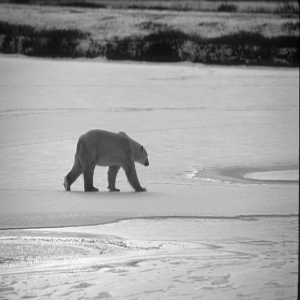

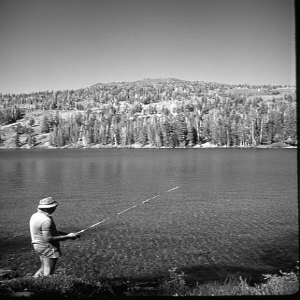

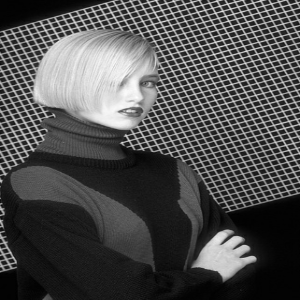

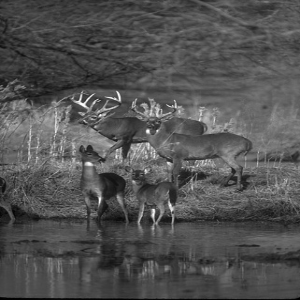

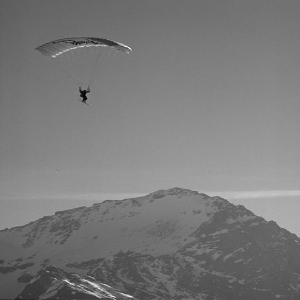

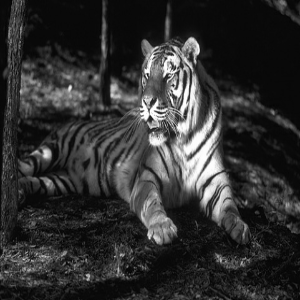

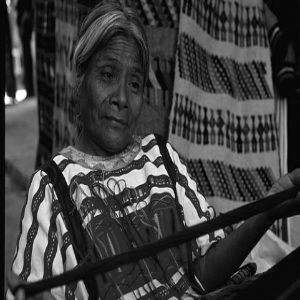

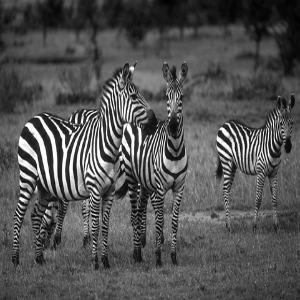

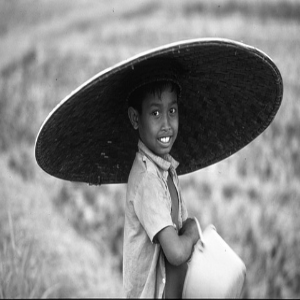

In [30]:
# Visualising i/p and o/p images that are fed to model for training
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))    # i/p images to model
    for img in batch[1]:
        display(array_to_img(img))    #output images for model

# Building the Model

In [31]:
channels = 1
inputs = keras.Input(shape=(None, None, channels))
x = layers.Conv2D(64, 5, padding='same', activation='tanh')(inputs)
x = layers.Conv2D(64, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(32, 3, padding='same', activation='tanh')(x)
x = layers.Conv2D(channels * (upscale_factor ** 2), 3, padding='same', activation='tanh')(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

model = keras.Model(inputs, outputs)
model.summary()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# some useful functions
def get_low_res_img(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )
def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

    def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display the PSNR - main metric we use to evaluate super-resolution performance.

**PSNR** : Peak Signal-to-Noise Ratio is a metric of how "closely" the super-resolved image reconstructed from its low-res value resembles the original high quality image.

In [ ]:
class ESPCNCallBack(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallBack, self).__init__()
        self.test_img = get_low_res_img(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [ ]:
epochs = 100
# we also need to save the model while training so as to make predictions later on
checkpoint_filepath = "/tmp/checkpoint"  # directory where model wts will be saved


model.compile(
    optimizer=keras.optimizers.Adam(lr = .001), loss=keras.losses.MeanSquaredError())

model.fit(
    train_ds, epochs=epochs, validation_data=valid_ds, verbose = 2, callbacks = [ESPNCallBack(), keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_filepath,
        save_weights_only=True,
        monitor="loss",
        mode="min",
        save_best_only=True,   # we will only save the best model, best => min MSE loss 
    )]
)


In [ ]:
# Loading the "best" model so that we can use it directly for making predictions without training
model.load_weights(checkpoint_filepath)

# Predictions :)

In [ ]:
# we also need to create a list of test images (with location) for inference model

test_img_paths = []
for file_name in os.listdir('/content/BSR/BSDS500/data/images/test/'):
  if file_name[-4:] = ".jpg":
    test_img_paths.append('/content/BSR/BSDS500/data/images/test/'+file_name)
    
)
test_img_paths.sort()


In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))